# 6. Credit Risk Prediction

This notebook contains lesson content completed for module 6 of the machine learning zoomcamp.

This is a binary classification problem where customers either default (1) or not (0). 

We will be using this dataset to learn about how decision trees and other ensemble models work and how to tune such models.

Dataset: [Credit Scoring Dataset](https://github.com/gastonstat/CreditScoring)

In [1]:
# Main Imports
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data Cleaning and preparation



In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

In [4]:
df = pd.read_csv("./assets/CreditScoring.csv")

In [5]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
status_values = {1: 'ok', 2: 'default', 0: 'unk'}

df.status = df.status.map(status_values)

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [10]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


### Missing values

In this dataset we are aware that missing values have been replaced with 99999999, so we need to replace them with NaNs.

There is also one unknown value in the target column so we will handle this by removing that row.

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [13]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [14]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [15]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

In [16]:
df[df.status != 'unk'].reset_index(drop=True)


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


### Train test split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [19]:
df_full_train.reset_index(drop=True)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,6,other,30,22,single,no,fixed,35,73.0,0.0,0.0,1086,1086
1,ok,45,owner,30,64,married,no,freelance,45,157.0,20000.0,0.0,1000,1588
2,ok,2,owner,60,30,married,yes,fixed,45,174.0,4000.0,0.0,2000,2250
3,ok,11,rent,60,28,married,no,fixed,59,144.0,0.0,0.0,1225,1360
4,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
3560,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
3561,default,24,other,60,41,married,yes,freelance,75,0.0,0.0,0.0,2200,2428
3562,default,2,rent,48,56,single,no,freelance,51,157.0,11000.0,4500.0,1000,2008


In [20]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [21]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [22]:
del df_train['status']
del df_val['status']
del df_test['status']

## 6.3 Decision Trees 

Here is an example of a decision tree we can create as a function of if and else statements:
![Decision Tree Example](./assets/dt_example.png)

In [23]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'
        


In [24]:
xi = df_train.iloc[0].to_dict()

In [25]:
assess_risk(xi)

'ok'

Now we have an understanding of the basics of how decision trees work, we can implement one using scikit learn

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [27]:
# First we need to create dictionaries for the feature matrix
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [28]:
# Then vectorise those dictionaries (equivalent to one hot encoding)
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [29]:
#Instantiate the decisiontree classifier and train it
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Testing on validation data

In [30]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [32]:
roc_auc_score(y_val, y_pred)

0.6605798588363267

This isn't a very good roc auc score. Let's see  what it was for the training set.

In [33]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

The auc is perfect at  1.0. This tells us that the model has overfit to the training data, which is why it does not predict well on the validation data in comparison to the training set.

Depth of the tree impacts the ability of the model to generalise. If we don't restrict the model will go as deep as it needs to to learn the patterns of the data, and so when presented with new data, it will struggle to predict.

Lets now retrain the model with a max depth of 3.

In [34]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [35]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [36]:
roc_auc_score(y_val, y_pred)

0.763427236430611

Still not the best but a much better performance on validation data.

In [37]:
from sklearn.tree import export_text, plot_tree

In [38]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- income <= 50.50
|   |   |   |--- class: 1
|   |   |--- income >  50.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 99.50
|   |   |   |--- class: 1
|   |   |--- income >  99.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 73.50
|   |   |   |--- class: 0
|   |   |--- income >  73.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- time <= 27.00
|   |   |   |--- class: 0
|   |   |--- time >  27.00
|   |   |   |--- class: 1



[Text(0.5, 0.875, 'records=no <= 0.5\ngini = 0.397\nsamples = 2673\nvalue = [1942.0, 731.0]'),
 Text(0.25, 0.625, 'seniority <= 6.5\ngini = 0.49\nsamples = 457\nvalue = [197, 260]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'income <= 50.5\ngini = 0.423\nsamples = 263\nvalue = [80, 183]'),
 Text(0.0625, 0.125, 'gini = 0.194\nsamples = 55\nvalue = [6, 49]'),
 Text(0.1875, 0.125, 'gini = 0.458\nsamples = 208\nvalue = [74, 134]'),
 Text(0.375, 0.375, 'income <= 99.5\ngini = 0.479\nsamples = 194\nvalue = [117, 77]'),
 Text(0.3125, 0.125, 'gini = 0.452\nsamples = 55\nvalue = [19, 36]'),
 Text(0.4375, 0.125, 'gini = 0.416\nsamples = 139\nvalue = [98.0, 41.0]'),
 Text(0.75, 0.625, 'job=partime <= 0.5\ngini = 0.335\nsamples = 2216\nvalue = [1745, 471]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'income <= 73.5\ngini = 0.284\nsamples = 1993\nvalue = [1651, 342]'),
 Text(0.5625, 0.125, 'gini = 0.474\nsamples = 373\nvalue = [229, 144]'),
 Text(0.6875, 0.125, 'gini = 0.215\nsamp

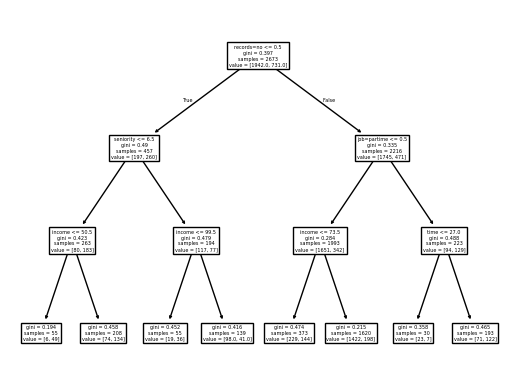

In [39]:
plot_tree(dt,feature_names=dv.get_feature_names_out(), )

## 6.4 Decision Tree Learning Algorithm

In [40]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


How do we find the best split?

When we have numerical colmuns we need numerical threshold to base rules on. At a feature node we need to decide what is true and what is false.

To do this we will test different thresholds to see which gives the best gini index.

In [41]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [42]:
impurity_scores = {}
for T in Ts:

    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    left_impurity = 1 - df_left.status.value_counts(normalize=True).max()
    print(left_impurity)
    display(df_right)
    right_impurity = 1 - df_right.status.value_counts(normalize=True).max()
    print(right_impurity)
    avg_imp = np.mean([left_impurity,right_impurity])
    print(np.round(avg_imp, 2))
    impurity_scores[T] = avg_imp
    print()

,assets,status
2,0,default


0.0


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


0.4285714285714286
0.21



,assets,status
1,2000,default
2,0,default


0.0


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


0.33333333333333337
0.17



,assets,status
1,2000,default
2,0,default
7,3000,default


0.0


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


0.19999999999999996
0.1



,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


0.25


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


0.25
0.25



,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


0.5


,assets,status
0,8000,default
6,9000,ok


0.5
0.5



,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


0.4285714285714286


,assets,status
6,9000,ok


0.0
0.21



In [43]:
impurity_scores

{0: np.float64(0.2142857142857143),
 2000: np.float64(0.16666666666666669),
 3000: np.float64(0.09999999999999998),
 4000: np.float64(0.25),
 5000: np.float64(0.5),
 8000: np.float64(0.2142857142857143)}

If we add more than one feature, we do the same and see which results in the lowest impurity and that will be the more important feature. Lets add an example debt feature to the example dataset.

In [44]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [45]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [46]:
features = {}


for feature, Ts in thresholds.items():
    impurity_scores = {}
    for T in Ts:
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        left_impurity = 1 - df_left.status.value_counts(normalize=True).max()
        print(left_impurity)
        display(df_right)
        right_impurity = 1 - df_right.status.value_counts(normalize=True).max()
        print(right_impurity)
        avg_imp = np.mean([left_impurity,right_impurity])
        print(np.round(avg_imp, 2))
        
        impurity_scores[T] = avg_imp
    features[feature] = impurity_scores
    print()

,assets,debt,status
2,0,1000,default


0.0


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


0.4285714285714286
0.21


,assets,debt,status
1,2000,1000,default
2,0,1000,default


0.0


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


0.33333333333333337
0.17


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


0.0


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


0.19999999999999996
0.1


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


0.25


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


0.25
0.25


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


0.5


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


0.5
0.5


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


0.4285714285714286


,assets,debt,status
6,9000,500,ok


0.0
0.21



,assets,debt,status
6,9000,500,ok


0.0


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


0.4285714285714286
0.21


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


0.33333333333333337


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


0.0
0.17


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


0.4285714285714286


,assets,debt,status
0,8000,3000,default


0.0
0.21



In [47]:
features

{'assets': {0: np.float64(0.2142857142857143),
  2000: np.float64(0.16666666666666669),
  3000: np.float64(0.09999999999999998),
  4000: np.float64(0.25),
  5000: np.float64(0.5),
  8000: np.float64(0.2142857142857143)},
 'debt': {500: np.float64(0.2142857142857143),
  1000: np.float64(0.16666666666666669),
  2000: np.float64(0.2142857142857143)}}

We can see that Assets was still the best column for making decisions better than debt.

After we make the best split we can continue splitting based off new criteria, but we need stopping criteria to stop the tree from over fitting:
- Group is already pure (0 impurity)
- Max depth reached
- Minimum size of group has been reached.


Decision Tree Learning Algoritm

- Find the best split
- Stop if Max depth is reached
- If left is suffciently large and not pure:
    - Repeat for Left
- If right is suffciently large and not pure:
    - Repeat for right


## 6.5 Decision Tree Parameter Tuning

In [48]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
print("Depth -> AUC ")
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"{depth} -> {auc:.3f}")

Depth -> AUC 
1 -> 0.613
2 -> 0.688
3 -> 0.763
4 -> 0.779
5 -> 0.784
6 -> 0.772
10 -> 0.702
15 -> 0.673
20 -> 0.662
None -> 0.674


In [49]:
scores = []

depths = [4, 5, 6]
min_samples = [1, 5, 10, 15, 20, 500, 100, 200]
for depth in depths:
    for ms in min_samples:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=ms)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, ms, auc))

In [50]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [51]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
20,6,20,0.802464
19,6,15,0.795124
22,6,100,0.793276
18,6,10,0.791360
23,6,200,0.788792
9,5,5,0.786916
14,5,100,0.786425
12,5,20,0.785229
17,6,5,0.784753
8,5,1,0.783647


In [52]:
df_scores_pivot = df_scores.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])

In [53]:
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.779  0.784  0.777
5                 0.779  0.787  0.785
10                0.774  0.783  0.791
15                0.771  0.780  0.795
20                0.784  0.785  0.802
100               0.767  0.786  0.793
200               0.765  0.778  0.789
500               0.671  0.671  0.671

In [54]:
from pypalettes import load_cmap

%matplotlib inline
cmap = load_cmap("X84")
palette = cmap.colors

Text(50.722222222222214, 0.5, 'min_samples_leaf')

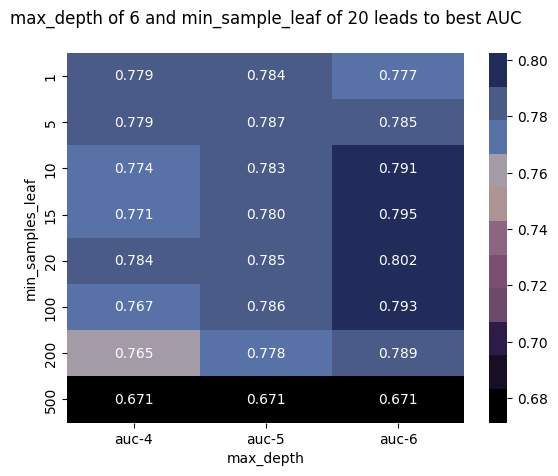

In [55]:
sns.heatmap(df_scores_pivot, annot=True, cmap=palette, fmt=".3f")
plt.title("max_depth of 6 and min_sample_leaf of 20 leads to best AUC\n")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")


Testing with all possible depths:

In [56]:
scores = []

depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_samples = [1, 5, 10, 15, 20, 500, 100, 200]

for depth in depths:
    for ms in min_samples:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=ms)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, ms, auc))

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)


In [57]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
52,10.0,20,0.802266
44,6.0,20,0.801787
60,15.0,20,0.801759
76,NaN,20,0.800733
68,20.0,20,0.799899


In [58]:
df_scores_pivot = df_scores.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])
df_scores_pivot = df_scores_pivot.round(3)

Text(158.22222222222223, 0.5, 'min_samples_leaf')

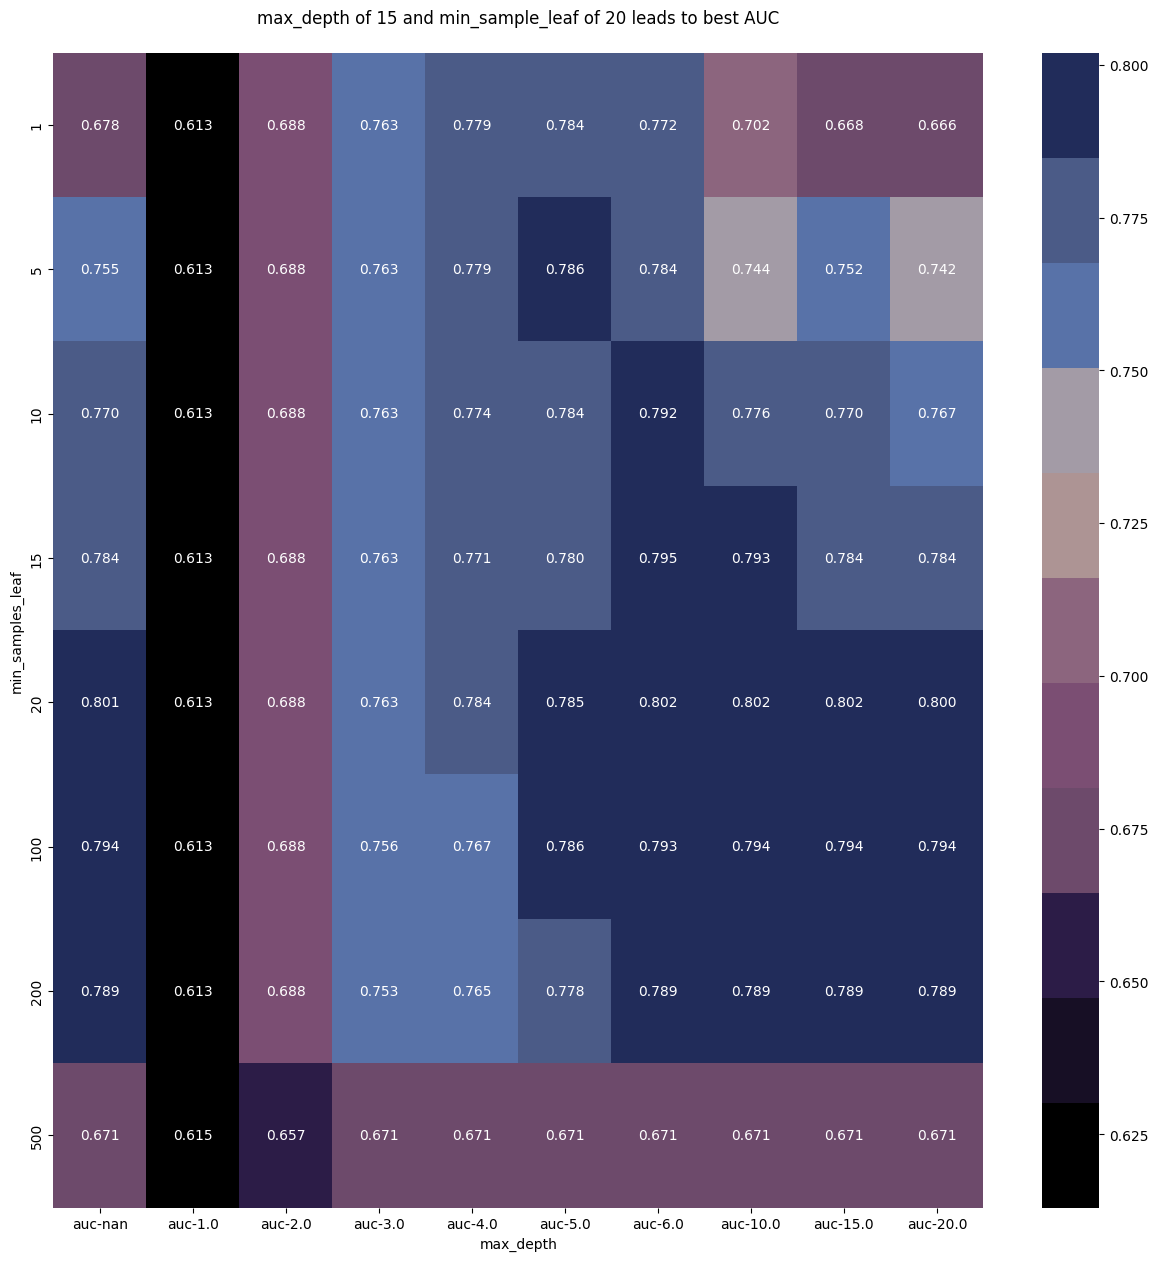

In [59]:
plt.figure(figsize=(15,15))
sns.heatmap(df_scores_pivot, annot=True, cmap=palette, fmt=".3f")
plt.title("max_depth of 15 and min_sample_leaf of 20 leads to best AUC\n")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")

Although the best AUC was with a max depth of 15, we may chose to use a smaller tree to reduce risk of overfitting. But if we plan to use a weak learner in an ensemble this may be less of a consideration.

## 6.6 Ensemble Learning and Random Forest

Ensemble learning methods take a group of weak learners and combine their outputs to get better results.

Random Forests specifically takes random decision trees and aggregates their results with majority voting system. These trees are built with random subsets of the data and randoome features.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [62]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [63]:
roc_auc_score(y_val, y_pred)

0.8135545556805399

Lets test some different values for number of estimators.

In [64]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [65]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

In [66]:
df_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,auc
18,190,0.836861
13,140,0.836401
14,150,0.836197
15,160,0.836188
19,200,0.836182


<Axes: xlabel='n_estimators', ylabel='auc'>

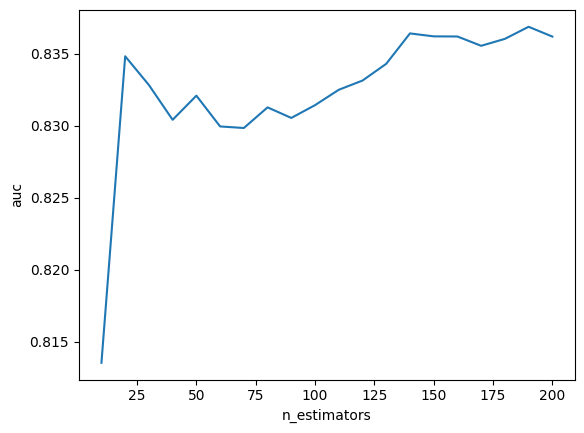

In [67]:
sns.lineplot(x=df_scores.n_estimators, y=df_scores.auc)

In [68]:
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((n, d, auc))

In [69]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,max_depth,auc
28,90,10,0.842989
35,160,10,0.842810
27,80,10,0.842798
34,150,10,0.842464
36,170,10,0.842446


In [70]:
df_scores_pivot = df_scores.pivot(index=['n_estimators'], columns=['max_depth'], values=['auc'])
df_scores_pivot

auc                    
max_depth           5         10        15
n_estimators                              
10            0.816836  0.808641  0.795279
20            0.822319  0.824145  0.819574
30            0.821957  0.825974  0.824955
40            0.824540  0.834874  0.825322
50            0.828756  0.839343  0.827108
60            0.831389  0.840962  0.829213
70            0.831685  0.842279  0.828175
80            0.830919  0.842798  0.830431
90            0.831166  0.842989  0.832668
100           0.831209  0.841308  0.832751
110           0.830770  0.840975  0.833184
120           0.829967  0.841073  0.832424
130           0.830004  0.842149  0.831280
140           0.829627  0.842303  0.833345
150           0.829015  0.842464  0.833549
160           0.829578  0.842810  0.832850
170           0.830418  0.842446  0.832863
180           0.830424  0.841500  0.833076
190           0.830993  0.840412  0.834779
200           0.830585  0.840375  0.835517

Text(0.5, 1.0, 'max_depth of 10 and n_estimators of 90 leads to best AUC\n')

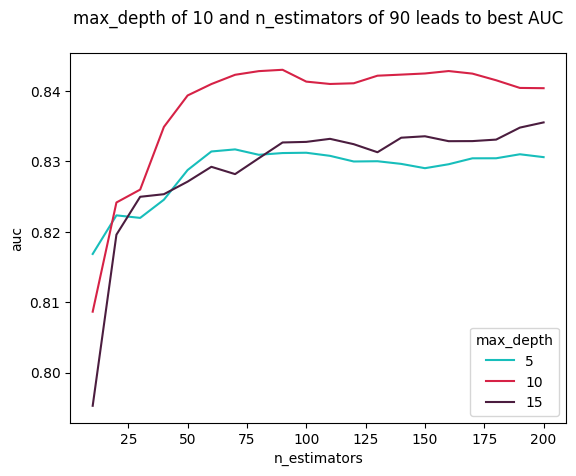

In [71]:
cmap = ['#17BEBBFF', '#D62246FF', '#4B1D3FFF']
sns.lineplot(data=df_scores, x='n_estimators', y='auc', hue='max_depth', palette=cmap)
plt.title("max_depth of 10 and n_estimators of 90 leads to best AUC\n")

Now lets tune min sample leaf

In [72]:
scores = []
for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(
            n_estimators=n, 
            max_depth=10, 
            min_samples_leaf=s,
            random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((n, s, auc))

In [73]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,n_estimators,min_samples_leaf,auc
8,90,1,0.842989
15,160,1,0.842810
7,80,1,0.842798
57,180,5,0.842637
59,200,5,0.842551


In [74]:
import plotly.graph_objects as go

sorted_scores = df_scores.sort_values(by='auc', ascending=False).head().round(4)

fig = go.Figure(data=[go.Table(
    header=dict(values=list(sorted_scores.columns),
                fill_color='rgb(23, 190, 187)',
                align='left'),
    cells=dict(values=[sorted_scores.n_estimators, sorted_scores.min_samples_leaf, sorted_scores.auc],
               fill_color='rgb(212, 244, 221)',
               align='left'))

])

fig.show()

Text(0.5, 1.0, 'min_samples_leaf of 1 and n_estimators of 90 leads to best AUC\n')

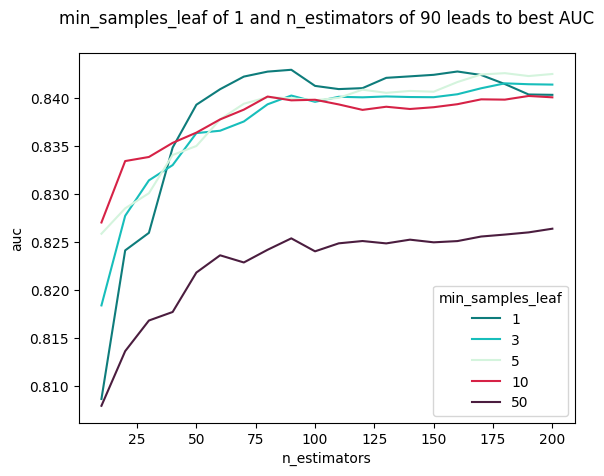

In [75]:
cmap = ['#0E7C7BFF', '#17BEBBFF', '#D4F4DDFF', '#D62246FF', '#4B1D3FFF']
sns.lineplot(data=df_scores, x='n_estimators', y='auc', hue='min_samples_leaf', palette=cmap)
plt.title("min_samples_leaf of 1 and n_estimators of 90 leads to best AUC\n")

In [76]:
rf = RandomForestClassifier(
            n_estimators=90, 
            max_depth=10, 
            min_samples_leaf=1,
            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,90
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6.7 Gradient Boosting and XGBoost

Boosting is a different scheme of ensemble method where we use models that take the error from the previous model to improve the current one. Models have to run sequentially.

XGboost is an implementation of this using trees.

In [77]:
import xgboost as xgb

In [80]:
features = list(dv.get_feature_names_out())

features

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [81]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [83]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    # 'nthreads': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [84]:
y_pred = model.predict(dval)

In [85]:
roc_auc_score(y_val, y_pred)

0.809991470846364

In [86]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [89]:
%%capture output
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    # 'nthreads': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  evals=watchlist,
                  num_boost_round=200)

In [90]:
s = output.stdout

In [93]:
line = s.split('\n')[0]

In [94]:
num_iter, train_auc, val_auc = line.split('\t')

In [95]:
int(num_iter.strip('[]'))

0

In [96]:
float(train_auc.split(':')[1])

0.85945

In [97]:
float(val_auc.split(':')[1])

0.79388

Now lets put this into a function to complete for all outputs...

In [98]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)

    return df_results


In [100]:
df_scores = parse_xgb_output(output)

In [104]:
df_scores

,num_iter,train_auc,val_auc
0,0,0.85945,0.79388
1,1,0.88516,0.80503
2,2,0.89806,0.81163
3,3,0.90636,0.81456
4,4,0.91874,0.82017
...,...,...,...
195,195,1.00000,0.80992
196,196,1.00000,0.81041
197,197,1.00000,0.81018
198,198,1.00000,0.81002


In [120]:
df_scores.sort_values(by='val_auc', ascending=False).head()

,num_iter,train_auc,val_auc
16,16,0.96435,0.82850
15,15,0.96295,0.82831
9,9,0.94702,0.82823
6,6,0.93286,0.82815
17,17,0.96699,0.82814


Text(0.5, 1.0, '16 iterations leads to best Validation AUC: 0.82850\n')

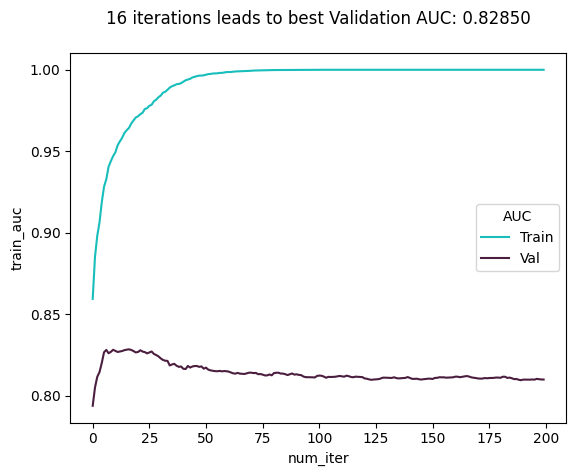

In [123]:
sns.lineplot(data=df_scores, x='num_iter', y='train_auc', label='Train', color='#17BEBBFF')
sns.lineplot(data=df_scores, x='num_iter', y='val_auc', label='Val', color='#4B1D3FFF')
plt.legend(title='AUC')
plt.title("16 iterations leads to best Validation AUC: 0.82850\n")

Text(0.5, 1.0, '16 iterations leads to best Validation AUC: 0.82850\n')

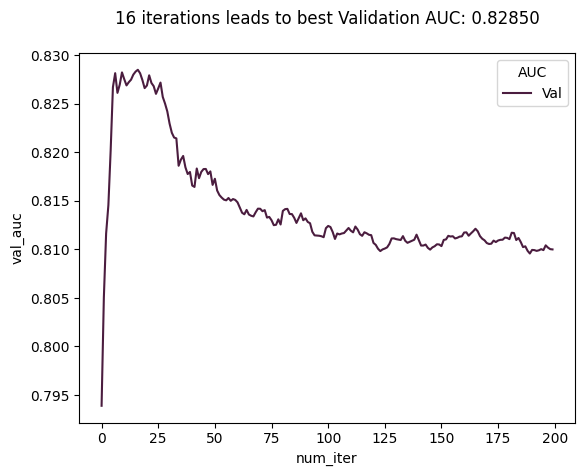

In [124]:
sns.lineplot(data=df_scores, x='num_iter', y='val_auc', label='Val', color='#4B1D3FFF')
plt.legend(title='AUC')
plt.title("16 iterations leads to best Validation AUC: 0.82850\n")